In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [2]:
# meta data
cluster_meta=pd.read_csv('../data/TableS7-cell_metadata.csv.gz',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('../data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


# compare with AIBS multi-cortex

In [3]:
# ! wget -O /scratch/AIBS_Human_multiple2019_metadata.csv https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_ctx_smart-seq/metadata.csv --no-check-certificate
# ! gdown -O /scratch/AIBS_Human_multiple2019_log2CPM.csv.gz  https://drive.google.com/file/d/17glfyorUmvwNn3_-7HZ7bMnFxO1Uf9Ix/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/allcelltypes_donoraveage_log2cpm+1.tsv.gz  https://drive.google.com/file/d/13mxue_FIoSq5LDIjjTmETsW-DAXAnS0n/view?usp=drive_link --fuzzy

AIBS_meta=pd.read_csv('/scratch/AIBS_Human_multiple2019_metadata.csv',index_col=0)
AIBS_rna=pd.read_csv('/scratch/AIBS_Human_multiple2019_log2CPM.csv.gz',index_col=0)
CZI_rna=pd.read_csv('/scratch/allcelltypes_donoraveage_log2cpm+1.tsv.gz',sep='\t',index_col=0)
CZI_rna=CZI_rna.loc[set(CZI_rna.index).intersection(set(gene_meta[gene_meta['fn']=='protein_coding'].index))]
CZI_rna.index=CZI_rna.index.map(genedict_idtoname)
CZI_rna = CZI_rna[~CZI_rna.index.duplicated(keep='first')]

AIBS_dict=pd.DataFrame(index=AIBS_rna.columns)
AIBS_dict['subclass_label']=AIBS_dict.index.map(dict(zip(AIBS_meta['cluster_label'],AIBS_meta['subclass_label'])))
AIBS_dict['subclass_label'] = pd.Categorical(AIBS_dict['subclass_label'], 
                                             categories = ['IT', 'L4 IT', 'L5/6 IT Car3', 'L5 ET', 'L5/6 NP','L6 CT', 'L6b','LAMP5',  'VIP', 'PAX6',  'SST', 'PVALB',
                                                        'Oligodendrocyte', 'OPC', 'Astrocyte', 'Microglia', 'Endothelial','Pericyte', 'VLMC'])

tmp=CZI_rna.loc[set(CZI_rna.index).intersection(set(AIBS_rna.index))].agg(['median','std'],axis=1)
tmp=tmp.join(gene_meta[['chr','gene_name']].set_index('gene_name'))
tmp=tmp[~tmp['chr'].str.contains('[XYM]')]
tmp = tmp[~tmp.index.duplicated(keep='first')]

gois=tmp[tmp['median']>0].sort_values('std').tail(500).index
print(f'use top {len(gois)} variable genes')
df=pd.DataFrame(index=CZI_rna.columns,columns=AIBS_rna.columns)
for i in CZI_rna.columns:
    for j in AIBS_rna.columns:
        df.loc[i,j],_=sc.stats.spearmanr(CZI_rna.loc[gois,i],AIBS_rna.loc[gois,j])

use top 500 variable genes


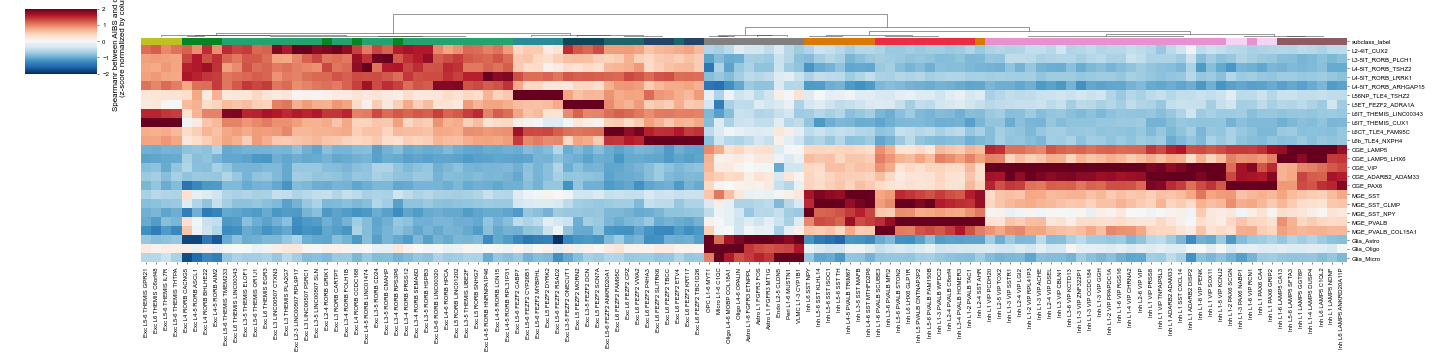

In [4]:
AIBS_palette={'IT':'#24a371',
'L4 IT':'#088523', 
'L5/6 IT Car3':'#bdc123',
'L5 ET':'#0c4657', 
'L5/6 NP':'#298b98',
'L6 CT':'#1f6466',
'L6b':'#234466',
'LAMP5':'#8e5a63', 
'VIP':'#e891d0', 
'PAX6':'#f4d3f5', 
'SST':'#d97807',
'PVALB':'#ea2c44',
'Oligodendrocyte':'grey', 'OPC':'grey', 'Astrocyte':'grey', 'Microglia':'grey', 'Endothelial':'grey','Pericyte':'grey', 'VLMC':'grey'}
row_colors_l1 = AIBS_dict['subclass_label'].astype('str').map(AIBS_palette)

sns.clustermap(df.T.dropna().T.astype(np.float).loc[cziplot.level2_order_full],
               row_cluster=False,col_cluster=True,
               z_score=1,cmap='RdBu_r',center=0,
               vmin=-2,vmax=2,
               # cbar_pos=(1,.5,.03,.15),
               method='ward',
              cbar_kws={'shrink':0.2,'label':'Spearmanr between AIBS and our data\n(z-score normalized by column)'},
              col_colors=row_colors_l1,
               dendrogram_ratio=0.1,
              figsize=(20,5))